

### Objectives:
Build a multi-headed model capable of detecting and assigning probabilities for different types of of toxicity such as: 
1. toxic
2. severe toxic
3. obscene
4. threat
5. insult
6. identity hate

The dataset is the comments from Wikipedia's discussionpages.

## Import relevant libraries and load the data

In [2]:

pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [4]:

import matplotlib.pyplot as plt
import nltk
import numpy as np
import re 
import pandas as pd
import string
import seaborn as sns

from nltk.corpus import stopwords  

from sklearn.feature_extraction.text import TfidfVectorizer


In [5]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/meghanab/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Loading the csv

In [6]:
data = pd.read_csv('train.csv')
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Entries with all 0 under the 6 categories are neutral and considered as non-toxic.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


## Exploratory Data Analysis

In [8]:
data.toxic.value_counts()

0    144277
1     15294
Name: toxic, dtype: int64

In [9]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [10]:
# we do not need the id
data_count=data.iloc[:,2:].sum()

In [11]:
data_count

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

/opt/homebrew/anaconda3/envs/myenv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


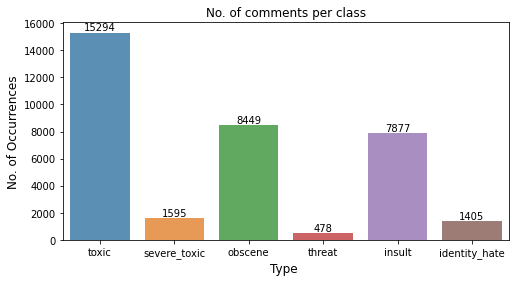

In [12]:

plt.figure(figsize=(8,4))

ax = sns.barplot(data_count.index, data_count.values, alpha=0.8)

plt.title("No. of comments per class")
plt.ylabel('No. of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)

#adding the text labels for each bar
rects = ax.patches
labels = data_count.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

## Preprocess the text

In [14]:
import re
import string

# remove all numbers with letters attached to them
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)

# '[%s]' % re.escape(string.punctuation),' ' - replace punctuation with white space
# .lower() - convert all strings to lowercase 
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

# Remove all '\n' in the string and replace it with a space
remove_n = lambda x: re.sub("\n", " ", x)

# Remove all non-ascii characters 
remove_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]',r' ', x)

# Apply all the lambda functions wrote previously through .map on the comments column
data['comment_text'] = data['comment_text'].map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)

data['comment_text'][0]

'explanation why the edits made under my username hardcore metallica fan were reverted  they weren t vandalisms  just closure on some gas after i voted at new york dolls fac  and please don t remove the template from the talk page since i m retired now        '

## Separating our dataset into 6 sections

In [15]:
data_tox = data.loc[:,['id','comment_text','toxic']]

In [16]:
data_tox['comment_text'][0]

'explanation why the edits made under my username hardcore metallica fan were reverted  they weren t vandalisms  just closure on some gas after i voted at new york dolls fac  and please don t remove the template from the talk page since i m retired now        '

In [17]:
data_tox['comment_text'][1]

'd aww  he matches this background colour i m seemingly stuck with  thanks    talk       january       utc '

In [18]:
data_sev = data.loc[:,['id','comment_text','severe_toxic']]

In [19]:
data_obs = data.loc[:,['id','comment_text','obscene']]

In [20]:
data_thr = data.loc[:,['id','comment_text','threat']]

In [21]:
data_ins = data.loc[:,['id','comment_text','insult']]

In [22]:
data_ide = data.loc[:,['id','comment_text','identity_hate']]

#### The data is heavily imbalanced. We see that comments that are toxic (and other forms of toxicity) make up less than 10% of the comments in the data.

#### For a start, we can take 5000 rows of comments that are toxic and concatenate them row-wise with those that are not toxic so that we have a balanced dataset.

In [23]:
data_tox.head()

,id,comment_text,toxic
0,0000997932d777bf,explanation why the edits made under my userna...,0
1,000103f0d9cfb60f,d aww he matches this background colour i m s...,0
2,000113f07ec002fd,hey man i m really not trying to edit war it...,0
3,0001b41b1c6bb37e,more i can t make any real suggestions on im...,0
4,0001d958c54c6e35,you sir are my hero any chance you remember...,0


In [24]:
data_tox_1 = data_tox[data_tox['toxic'] == 1].iloc[0:5000,:]
data_tox_1.shape

(5000, 3)

In [25]:
data_tox_0 = data_tox[data_tox['toxic'] == 0].iloc[0:5000,:]

In [26]:
data_tox_done = pd.concat([data_tox_1, data_tox_0], axis=0)
data_tox_done.shape

(10000, 3)

### Not all categories have 5000 rows. So we count them first and make them balanced.

In [27]:
data_sev[data_sev['severe_toxic'] == 1].count()


id              1595
comment_text    1595
severe_toxic    1595
dtype: int64

In [28]:
data_sev_1 = data_sev[data_sev['severe_toxic'] == 1].iloc[0:1595,:]
data_sev_0 = data_sev[data_sev['severe_toxic'] == 0].iloc[0:1595,:]
data_sev_done = pd.concat([data_sev_1, data_sev_0], axis=0)
data_sev_done.shape

(3190, 3)

### We only had 1,595 comments that are severely toxic. We combine it together with another 1,595 comments that are not toxic to form a new dataset that is balanced. We repeat this for all other categories.

In [29]:
data_obs[data_obs['obscene'] == 1].count()

id              8449
comment_text    8449
obscene         8449
dtype: int64

In [30]:
data_obs_1 = data_obs[data_obs['obscene'] == 1].iloc[0:5000,:]
data_obs_0 = data_obs[data_obs['obscene'] == 0].iloc[0:5000,:]
data_obs_done = pd.concat([data_obs_1, data_obs_0], axis=0)
data_obs_done.shape

(10000, 3)

In [31]:
data_thr[data_thr['threat'] == 1].count()

id              478
comment_text    478
threat          478
dtype: int64

The number of threat comments of 478 is too miniscule when addded with another 478 clean comments for a proper analysis. We decided that the clean comments will comprise 80% at the most of the dataset, as shown below.

In [32]:
data_thr_1 = data_thr[data_thr['threat'] == 1].iloc[0:478,:]

# We include 1912 comments that have no threat so that the data with threat (478) will represent 20% of the dataset.
data_thr_0 = data_thr[data_thr['threat'] == 0].iloc[0:1912,:]  
data_thr_done = pd.concat([data_thr_1, data_thr_0], axis=0)
data_thr_done.shape

(2390, 3)

In [33]:
data_ins[data_ins['insult'] == 1].count()

id              7877
comment_text    7877
insult          7877
dtype: int64

In [34]:
data_ins_1 = data_ins[data_ins['insult'] == 1].iloc[0:5000,:]
data_ins_0 = data_ins[data_ins['insult'] == 0].iloc[0:5000,:]
data_ins_done = pd.concat([data_ins_1, data_ins_0], axis=0)
data_ins_done.shape

(10000, 3)

In [35]:
data_ide[data_ide['identity_hate'] == 1].count()

id               1405
comment_text     1405
identity_hate    1405
dtype: int64

In [36]:
data_ide_1 = data_ide[data_ide['identity_hate'] == 1].iloc[0:1405,:] # 20%
data_ide_0 = data_ide[data_ide['identity_hate'] == 0].iloc[0:5620,:] # 80%
data_ide_done = pd.concat([data_ide_1, data_ide_0], axis=0)
data_ide_done.shape

(7025, 3)

Number of comments that fall into the following categories:

- Toxic (14,000+) 
- Severe Toxic (1595)
- Obscene (8449)
- Threat (478)
- Insult (7877)
- Identity Hate (1405)

#### Balanced Class

|                      | DF name       | No. of pts (1) | No. of pts (0) | Total data pts |
|----------------------|---------------|----------------|----------------|----------------|
| Toxic                | data_tox_done | 5000           | 5000           | 10000          |
| Severe Toxic         | data_sev_done | 1595           | 1595           | 3190           |
| Obscene (8449)       | data_obs_done | 5000           | 5000           | 10000          |
| Threat (478)         | data_thr_done | 478            | 1912           | 2390           |
| Insult (7877)        | data_ins_done | 5000           | 5000           | 10000          |
| Identity Hate (1405) | data_ide_done | 1405           | 5620           | 7025           |

### Import relevant packages for modelling

In [37]:
# Import packages for pre-processing
from sklearn import preprocessing

# Import tools to split data and evaluate model performance
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score

# Import ML algos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier


### Creating a  function that takes in a dataset  toxicity label, 

In [38]:
import time

def cv_tf_train_test(df_done,label):
    X = df_done.comment_text
    y = df_done[label]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    cv1 = TfidfVectorizer(ngram_range=(1,3), stop_words='english')
    X_train_cv1 = cv1.fit_transform(X_train) # Learn the vocabulary dictionary and return term-document matrix
    X_test_cv1  = cv1.transform(X_test)      # Learn a vocabulary dictionary of all tokens in the raw documents.'
    lr = LogisticRegression()
    lr.fit(X_train_cv1, y_train)
    print('lr done')
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_cv1, y_train)
    bnb = BernoulliNB()
    bnb.fit(X_train_cv1, y_train)
    print('bnb done')    
    mnb = MultinomialNB()
    mnb.fit(X_train_cv1, y_train)
    print('mnb done')    
    svm_model = LinearSVC()
    svm_model.fit(X_train_cv1, y_train)
    randomforest = RandomForestClassifier(n_estimators=100, random_state=42)
    randomforest.fit(X_train_cv1, y_train)
    print('rdf done')    
    # Creating a list of F1 score of all models 
    f1_score_data = {'F1 Score':[f1_score(lr.predict(X_test_cv1), y_test), f1_score(knn.predict(X_test_cv1), y_test), 
                                f1_score(bnb.predict(X_test_cv1), y_test), f1_score(mnb.predict(X_test_cv1), y_test),
                                f1_score(svm_model.predict(X_test_cv1), y_test), f1_score(randomforest.predict(X_test_cv1), y_test)]} 
                          
    # Creating a dataframe with the model names as column labels
    df_f1 = pd.DataFrame(f1_score_data, index=['Log Regression','KNN', 'BernoulliNB', 'MultinomialNB', 'SVM', 'Random Forest'])  

    return df_f1


### Creating a TF-IDF vectorizer object for each category and calculate the F1 scores across all models

In [39]:

t0 = time.time()
df_tox_cv = cv_tf_train_test(data_tox_done, 'toxic')
df_tox_cv.rename(columns={'F1 Score': 'F1 Score(toxic)'}, inplace=True)
t1 = time.time()
total = 'Time taken: {} seconds'.format(t1-t0)
print(total)
df_tox_cv


lr done
bnb done
mnb done
rdf done
Time taken: 20.851431131362915 seconds


,F1 Score(toxic)
Log Regression,0.852257
KNN,0.075094
BernoulliNB,0.713379
MultinomialNB,0.848336
SVM,0.868721
Random Forest,0.810054


In [40]:

t0 = time.time()
df_sev_cv = cv_tf_train_test(data_sev_done, 'severe_toxic')
df_sev_cv.rename(columns={'F1 Score': 'F1 Score(severe_toxic)'}, inplace=True)
t1 = time.time()
total = 'Time taken: {} seconds'.format(t1-t0)
print(total)
df_sev_cv

lr done
bnb done
mnb done
rdf done
Time taken: 2.8033268451690674 seconds


,F1 Score(severe_toxic)
Log Regression,0.929336
KNN,0.890855
BernoulliNB,0.701754
MultinomialNB,0.948560
SVM,0.940439
Random Forest,0.936259


In [41]:

t0 = time.time()
df_obs_cv = cv_tf_train_test(data_obs_done, 'obscene')
df_obs_cv.rename(columns={'F1 Score': 'F1 Score(obscene)'}, inplace=True)
t1 = time.time()
total = 'Time taken: {} seconds'.format(t1-t0)
print(total)
df_obs_cv

lr done
bnb done
mnb done
rdf done
Time taken: 19.405652046203613 seconds


,F1 Score(obscene)
Log Regression,0.909152
KNN,0.471733
BernoulliNB,0.718396
MultinomialNB,0.896482
SVM,0.917160
Random Forest,0.885190


In [42]:

t0 = time.time()
df_thr_cv = cv_tf_train_test(data_thr_done, 'threat')
df_thr_cv.rename(columns={'F1 Score': 'F1 Score(threat)'}, inplace=True)
t1 = time.time()
total = 'Time taken: {} seconds'.format(t1-t0)
print(total)
df_thr_cv

lr done
bnb done
mnb done
rdf done
Time taken: 1.7828500270843506 seconds


,F1 Score(threat)
Log Regression,0.552995
KNN,0.716981
BernoulliNB,0.012903
MultinomialNB,0.219653
SVM,0.798561
Random Forest,0.728000


In [43]:

t0 = time.time()
df_ins_cv = cv_tf_train_test(data_ins_done, 'insult')
df_ins_cv.rename(columns={'F1 Score': 'F1 Score(insult)'}, inplace=True)
t1 = time.time()
total = 'Time taken: {} seconds'.format(t1-t0)
print(total)
df_ins_cv

lr done
bnb done
mnb done
rdf done
Time taken: 20.451332807540894 seconds


,F1 Score(insult)
Log Regression,0.893703
KNN,0.101110
BernoulliNB,0.718167
MultinomialNB,0.883152
SVM,0.906096
Random Forest,0.854946


In [44]:

t0 = time.time()
df_ide_cv = cv_tf_train_test(data_ide_done, 'identity_hate')
df_ide_cv.rename(columns={'F1 Score': 'F1 Score(identity_hate)'}, inplace=True)
t1 = time.time()
total = 'Time taken: {} seconds'.format(t1-t0)
print(total)
df_ide_cv

lr done
bnb done
mnb done
rdf done
Time taken: 9.702788829803467 seconds


,F1 Score(identity_hate)
Log Regression,0.677010
KNN,0.119149
BernoulliNB,0.004535
MultinomialNB,0.251969
SVM,0.805195
Random Forest,0.706044


In [45]:
# combining the dataframes into a master dataframe to compare F1 scores across all categories.
f1_all = pd.concat([df_tox_cv, df_sev_cv, df_obs_cv, df_ins_cv, df_thr_cv, df_ide_cv], axis=1)
f1_all


,F1 Score(toxic),F1 Score(severe_toxic),F1 Score(obscene),F1 Score(insult),F1 Score(threat),F1 Score(identity_hate)
Log Regression,0.852257,0.929336,0.909152,0.893703,0.552995,0.677010
KNN,0.075094,0.890855,0.471733,0.101110,0.716981,0.119149
BernoulliNB,0.713379,0.701754,0.718396,0.718167,0.012903,0.004535
MultinomialNB,0.848336,0.948560,0.896482,0.883152,0.219653,0.251969
SVM,0.868721,0.940439,0.917160,0.906096,0.798561,0.805195
Random Forest,0.810054,0.936259,0.885190,0.854946,0.728000,0.706044


### TFIDF is the Best Model

In [46]:
X = data_tox_done.comment_text
y = data_tox_done['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initiate a Tfidf vectorizer
tfv = TfidfVectorizer(ngram_range=(1,3), stop_words='english')

X_train_fit = tfv.fit_transform(X_train)  
X_test_fit = tfv.transform(X_test)  

randomforest = RandomForestClassifier(n_estimators=100, random_state=42)

# Train our SVM model with the X training data converted into Count Vectorized format with the Y training data
randomforest.fit(X_train_fit, y_train)
randomforest.predict(X_test_fit)



array([0, 1, 1, ..., 1, 1, 1])

In [47]:
# Sample Prediction
comment1 = ['You piece of shit']
comment2 = ['What is up garden apple doing']

comment1_vect = tfv.transform(comment1)
randomforest.predict_proba(comment1_vect)[:,1]

array([0.97608333])

In [48]:
comment2_vect = tfv.transform(comment2)
randomforest.predict_proba(comment2_vect)[:,1]

array([0.23704928])

### Pickling the Random Forest Model to build flask based web app

In [49]:
import pickle

In [50]:
def pickle_model(df, label):
    
    X = df.comment_text
    y = df[label]

 
    tfv = TfidfVectorizer(ngram_range=(1,3), stop_words='english')
    X_vect = tfv.fit_transform(X)  
    # Writing to the file in Binary mode(wb), written in byte objects
    with open(r"{}.pkl".format(label + '_vect'), "wb") as f:   
        pickle.dump(tfv, f)   
        
    randomforest = RandomForestClassifier(n_estimators=100, random_state=42)
    randomforest.fit(X_vect, y)
    with open(r"{}.pkl".format(label + '_model'), "wb") as f:  
        pickle.dump(randomforest, f)
        

In [51]:
#Further notebooks to have the pickled model and Flask code